# 1. Setup and Imports

In [ ]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
from scipy import signal
#import wave, math
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import pairwise_distances
from statsmodels.tsa.stattools import grangercausalitytests
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from dtaidistance import dtw
from scipy.spatial.distance import squareform

# Data Setup

In [ ]:
# Change base_dir and output_dir according to your environment
base_dir = "Data/"
output_dir = "Figures/"

covid_dir = base_dir + "covid_rate_of_change_date_adjusted/"
economic_dir = base_dir + "economic_numpys/"

## Causes


In [ ]:
causes = []
states = np.load(file=base_dir + "state_names.npy", allow_pickle=True)
not_stationary = ["AZ","MA","NV","SC","ID"]
state_labels = []
for state in states:
  if state in not_stationary:
    continue
  temp = np.load(file=covid_dir + state + "_rate_of_change_date_adjusted.npy")
  causes.append(temp)
  state_labels.append(state)
print(state_labels)
print(len(state_labels))

['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'IL', 'IN', 'IA', 'KS', 'LA', 'ME', 'MD', 'MI', 'MN', 'NE', 'NH', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OR', 'PA', 'RI', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WY', 'KY', 'MS', 'MO', 'ND', 'OK', 'SD', 'VT', 'WV', 'MT', 'AK']
46


## Effects

In [ ]:
econ_names = ["dow_jones","s_and_p","nasdaq","wti","emqq","jets"]
effects = []
for name in econ_names:
  temp = np.load(file=economic_dir + name +  "_first_order_adjusted.npy")
  effects.append(temp)
print(effects[0].shape)

(178,)


# Baseline Clusterings

## Just Clustering the causes

### Euclidean

In [ ]:
scaler = StandardScaler()
causal_timeseries_standardized = scaler.fit_transform(causes)
effect_timeseries_standardized = scaler.fit_transform(effects)

In [ ]:
def get_euclidean_distance_matrix(causal_timeseries, effect_timeseries):
    euc_results = []
    for c in causal_timeseries:
        one_row_result = []
        for e in effect_timeseries:
            temp_dist = math.dist(c, e)
            one_row_result.append(temp_dist)
        euc_results.append(one_row_result)

    return np.array(euc_results)

def get_dtw_distance_matrix(causal_timeseries, effect_timeseries):
    dtw_dist_matrix =[]
    for input in causal_timeseries:
        row = []
        for effect in effect_timeseries:
            distance = dtw.distance_fast(input, effect)
            row.append(distance)
        dtw_dist_matrix.append(row)
    return np.array(dtw_dist_matrix)

In [ ]:
def get_clustermap(distance_matrix, num_clusters, figname, print_fig):
    if len(distance_matrix.shape) == 2 and distance_matrix.shape[0] == distance_matrix.shape[1]:
        distance_matrix_modified = squareform(distance_matrix) # linkage function wants a condensed upper triangular of the symmetric distance matrix
    linkage_matrix = linkage(distance_matrix_modified, method='complete')
    cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    # Calculate internal index (e.g., Silhouette Score)
    # Note: `silhouette_score` requires a distance matrix and cluster labels
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')

    if (print_fig):
        # Create a clustermap using the euc distance matrix
        sns.set(font_scale=1)
        raw_clustermap = sns.clustermap(distance_matrix,
                                        row_linkage=linkage_matrix,
                                        col_linkage=linkage_matrix,
                                        col_cluster=True,
                                        cmap='rocket',
                                        figsize=(10,10),
                                        yticklabels=state_labels,
                                        xticklabels=state_labels)
        # raw_clustermap.ax_heatmap.set_title(f'\nSilhouette: {silhouette_avg:.2f}')

        # Adjusting tick parameters to ensure both tick labels and marks are shown
        raw_clustermap.ax_heatmap.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        raw_clustermap.ax_heatmap.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        # Ensure tick marks are visible
        raw_clustermap.ax_heatmap.xaxis.set_ticks_position('bottom')
        raw_clustermap.ax_heatmap.yaxis.set_ticks_position('right')
        raw_clustermap.ax_heatmap.tick_params(labelsize=12)

        plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        raw_clustermap.savefig(output_dir + figname + ".png")

        print("Silhouette_avg: ", silhouette_avg)
    return silhouette_avg

Silhouette_avg:  0.6880904832648657


0.6880904832648657

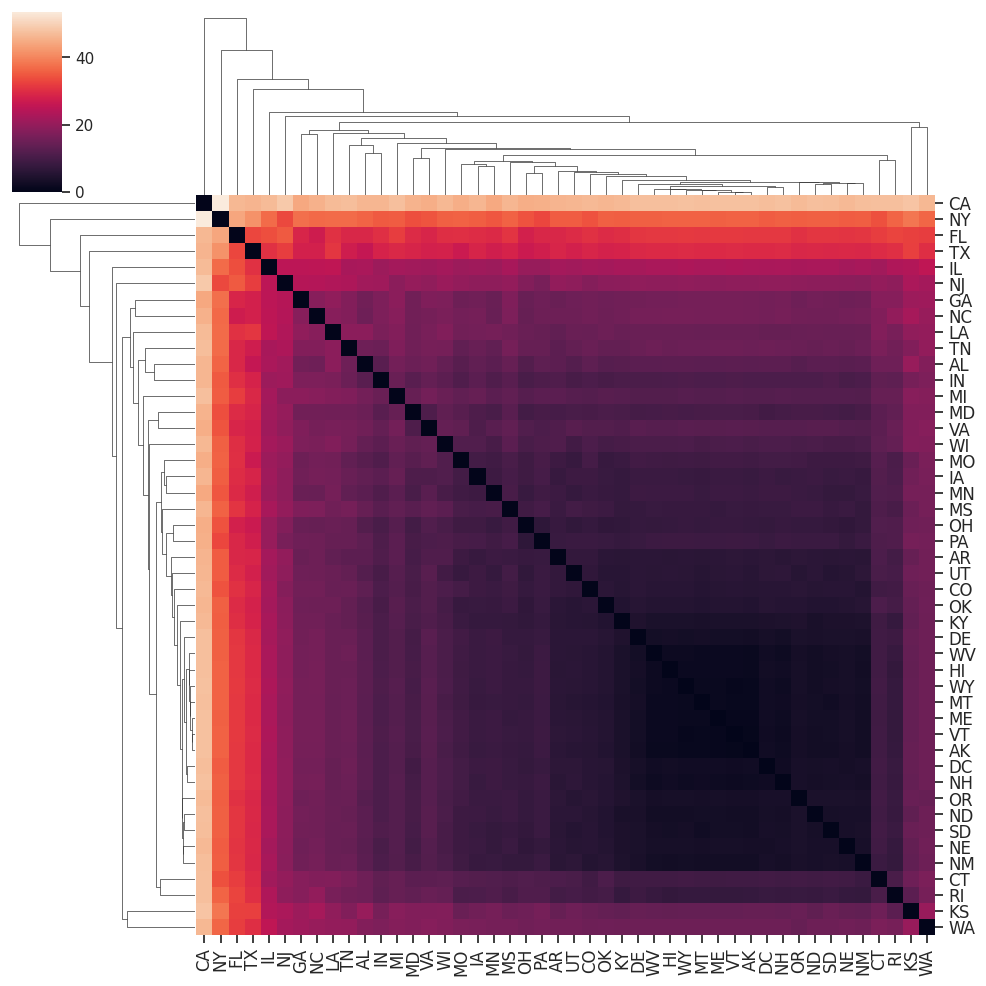

In [ ]:
euc_results_just_A = get_euclidean_distance_matrix(causal_timeseries_standardized, causal_timeseries_standardized)
get_clustermap(euc_results_just_A, 2, "euclidean_cause_only_clustermap", True)

### Dynamic Time Warping (DTW)

Silhouette_avg:  0.6672625027579682


0.6672625027579682

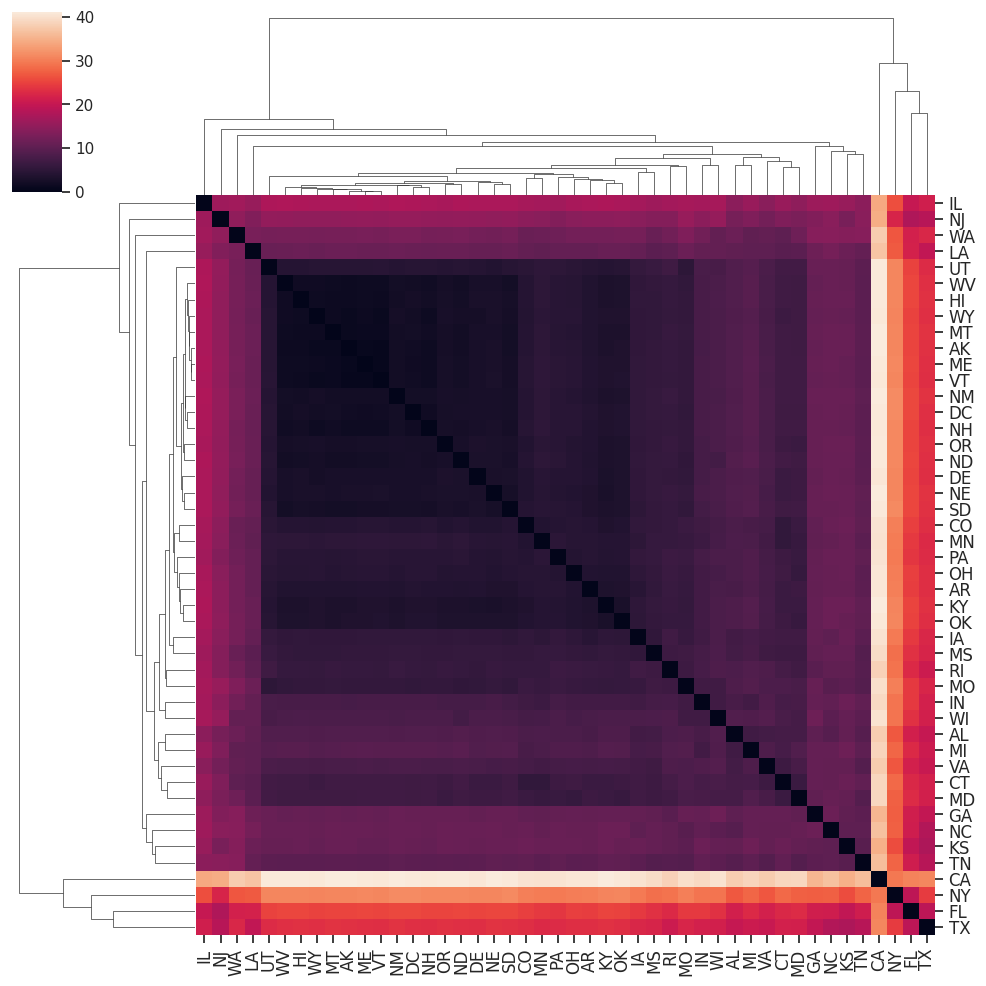

In [ ]:
dtw_distances = get_dtw_distance_matrix(causal_timeseries_standardized, causal_timeseries_standardized)
get_clustermap(dtw_distances, 2, "dtw_cause_only_clustermap", True)

## Clustering alpha (cause) based on distances to beta (effect)

### Euclidean

In [ ]:
euc_a_b_dist_matrix = get_euclidean_distance_matrix(causal_timeseries_standardized, effect_timeseries_standardized)
euc_a_b_affinity_matrix = pairwise_distances(euc_a_b_dist_matrix, metric='cosine')
for c in [2,3,4]:
    sil_avg = get_clustermap(euc_a_b_affinity_matrix, c, "", False)
    print("Silhouette avg for ", c, " clusters: ", sil_avg)


Silhouette avg for  2  clusters:  0.7694737086451157
Silhouette avg for  3  clusters:  0.7451622217204475
Silhouette avg for  4  clusters:  0.7630792144486516


Silhouette_avg:  0.7630792144486516


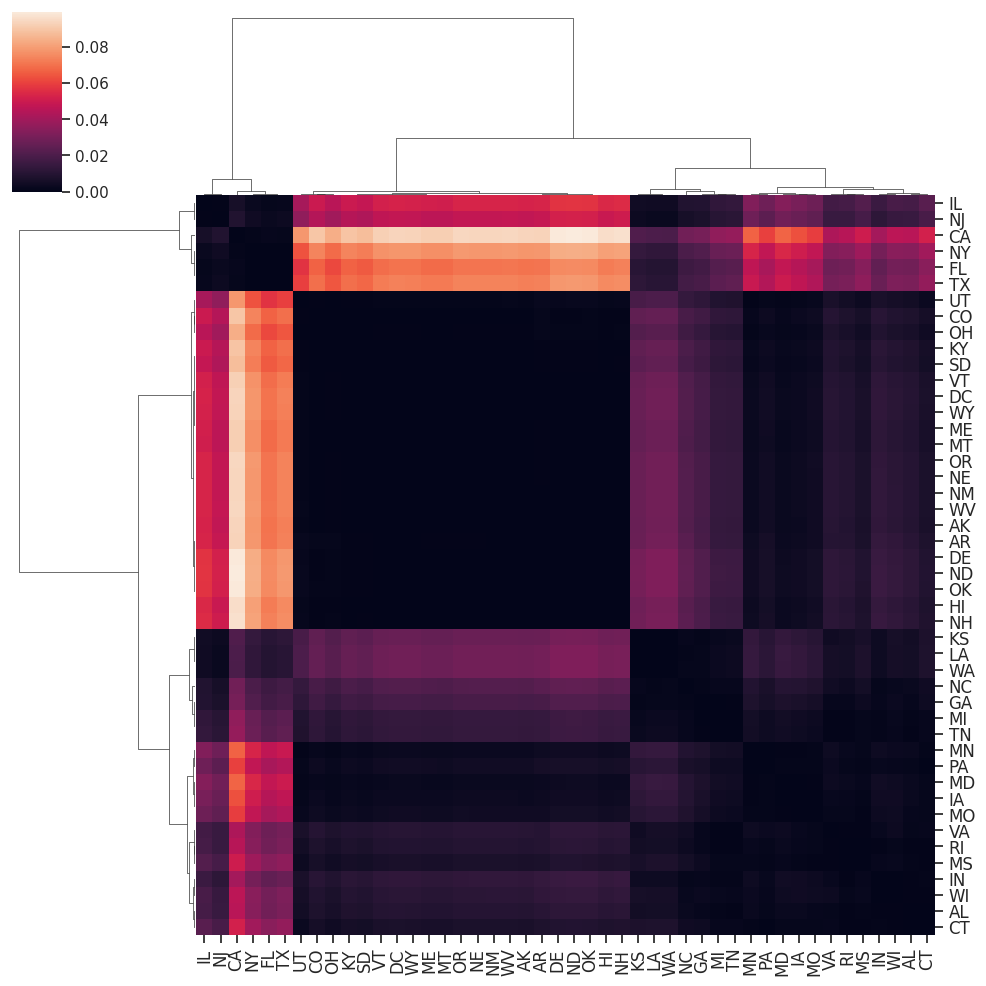

In [ ]:
temp = get_clustermap(euc_a_b_affinity_matrix, 4, "euclidean_cause_to_effect_affinity_clustermap", True)

### DTW

In [ ]:
dtw_a_b_dist_matrix = get_dtw_distance_matrix(causal_timeseries_standardized, effect_timeseries_standardized)
dtw_a_b_affinity_matrix = pairwise_distances(dtw_a_b_dist_matrix, metric='cosine')
for c in [2,3,4]:
    sil_avg = get_clustermap(dtw_a_b_affinity_matrix, c, "", False)
    print("Silhouette avg for ", c, " clusters: ", sil_avg)


Silhouette avg for  2  clusters:  0.7206580027919312
Silhouette avg for  3  clusters:  0.8360319347963145
Silhouette avg for  4  clusters:  0.8028733082291732


Silhouette_avg:  0.8360319347963145


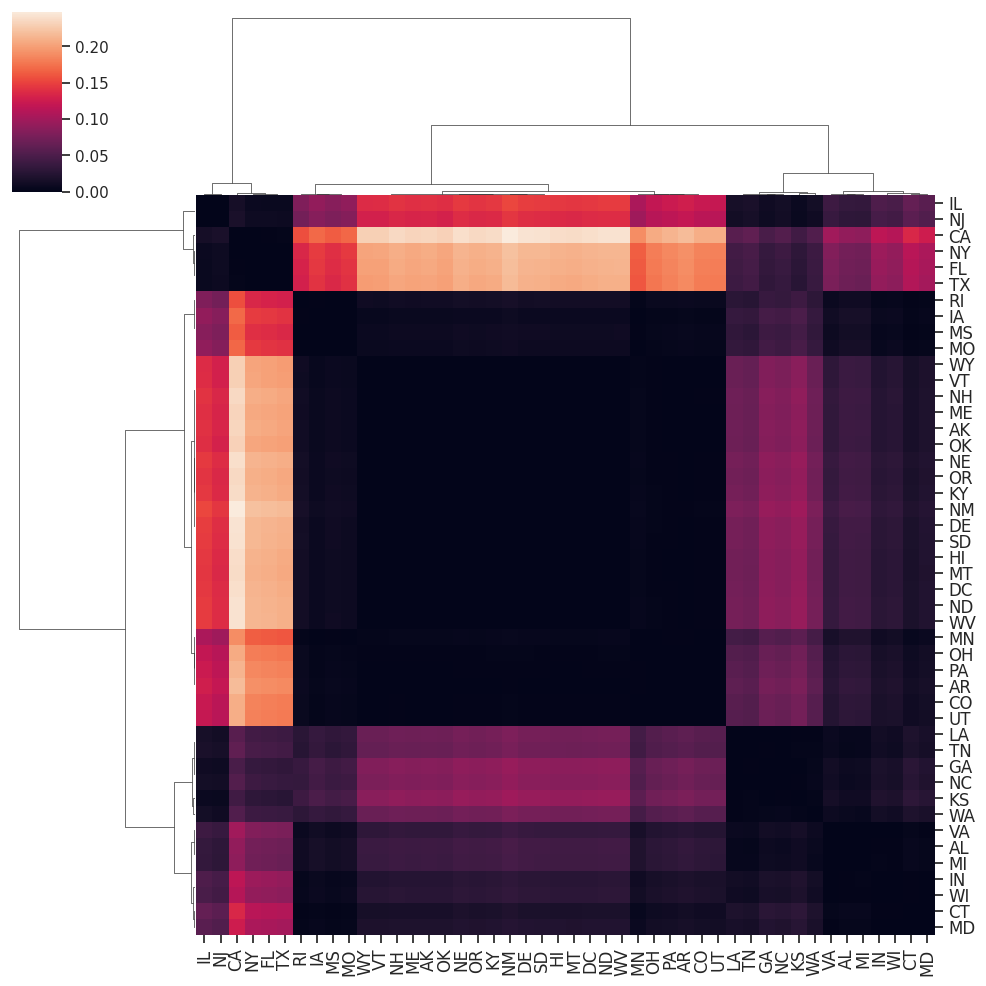

In [ ]:
temp = get_clustermap(dtw_a_b_affinity_matrix, 3, "dtw_cause_to_effect_affinity_clustermap", True)

# Granger

## Perform Granger Pairwise Testing

In [ ]:
import warnings
warnings.filterwarnings('ignore')
granger_results = []
for cts in causes:
    gres = []
    for ets in effects:
        g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
        results = grangercausalitytests(g_input, maxlag=21, verbose=0)
        p_vals = []
        for lag in results:
            p_vals.append(results[lag][0]['ssr_ftest'][1])
        result = np.min(p_vals)
        gres.append(result)
    granger_results.append(gres)
granger_results = np.array(granger_results)

### Clustering Granger Influence Matrix (i.e. states' covid timeseries vs market timeseries)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

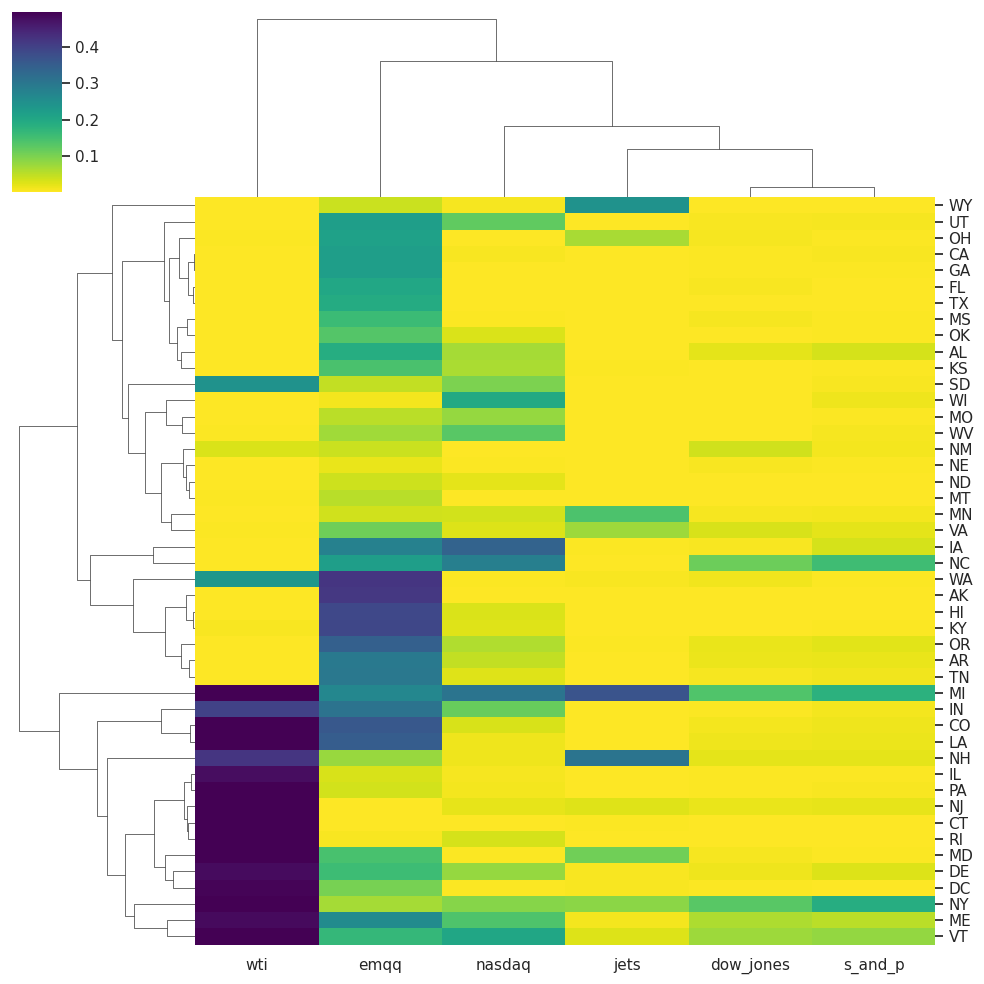

In [ ]:
from google.colab import files
granger_results_inv = 1-1/(1+np.exp(-10*granger_results - 0.01))
x_axis_labels = ["dow_jones","s_and_p","nasdaq","wti","emqq","jets"]
y_axis_labels = state_labels
cgrid = sns.clustermap(granger_results_inv,
                cmap='viridis_r',
                metric='euclidean',
                method='complete',
                figsize=(10,10), xticklabels=x_axis_labels, yticklabels=y_axis_labels)
a = 4
cgrid.savefig("state_vs_economic_indicators_heat_map.png")
files.download("state_vs_economic_indicators_heat_map.png")

In [ ]:
def search_params_for_granger(granger_results, num_clusters):
    # Parameters
    gammas = [10, 25, 50, 75, 100]
    thresholds = [0.01, 0.05]
    search_data_for_table = [["Number of Clusters", "Threshold","Gamma", "Silhouette Score"]]
    for c in range(2,num_clusters+1):
        # Loop over gamma and threshold combinations
        for j, threshold in enumerate(thresholds):
            for i, gamma in enumerate(gammas):
                # Transform granger_results using the specified gamma and threshold
                granger_results_inv = 1 - 1 / (1 + np.exp(-gamma * (granger_results - threshold)))

                # Calculate pairwise distances
                temp_xdata = pairwise_distances(granger_results_inv, metric='cosine')

                # Perform hierarchical clustering
                linkage_matrix = linkage(squareform(temp_xdata), method='complete')

                # Get cluster labels for a fixed number of clusters (e.g., 3 clusters)
                cluster_labels = fcluster(linkage_matrix, t=c, criterion='maxclust')

                # Calculate internal index (e.g., Silhouette Score)
                # Note: `silhouette_score` requires a distance matrix and cluster labels
                # if(gamma > 75 and threshold == 0.01):
                #     print(cluster_labels)
                if (len(np.unique(cluster_labels)) == 1):
                    search_data_for_table.append([c, threshold, gamma, "null"])
                    continue
                silhouette_avg = silhouette_score(temp_xdata, cluster_labels, metric='precomputed')

                search_data_for_table.append([c, threshold, gamma, round(silhouette_avg,6)])
    return search_data_for_table

In [ ]:
search_data_for_table = search_params_for_granger(granger_results, 4)

In [ ]:
# prompt: use tabulate to print my mse arrays with the use arrays columnwise and the noise along the rows

from tabulate import tabulate

def bold_text(text):
    return f"\033[1m{text}\033[0m"

# table_data = [
#     ["Noise Level", "AIC", "BIC", "HQ", "LR5", "LR1", "SLR5", "SLR1", "Granger"],
#     ["Low Noise", aic_maes[0], bic_maes[0], hq_maes[0],  og_seqlr5_maes[0], og_seqlr1_maes[0], og_slr5_maes[0], og_slr1_maes[0], bold_text(granger_maes[0])],
#     ["Medium Noise", aic_maes[1],  bic_maes[1], hq_maes[1], og_seqlr5_maes[1], og_seqlr1_maes[1], og_slr5_maes[1],bold_text(og_slr1_maes[1]), granger_maes[1]],
#     ["High Noise", aic_maes[2], bic_maes[2], hq_maes[2],  og_seqlr5_maes[2], og_seqlr1_maes[2], og_slr5_maes[2], og_slr1_maes[2], bold_text(granger_maes[2])]
# ]

print(tabulate(search_data_for_table, headers="firstrow", tablefmt="grid"))


+----------------------+-------------+---------+--------------------+
|   Number of Clusters |   Threshold |   Gamma | Silhouette Score   |
+======================+=============+=========+====================+
|                    2 |        0.01 |      10 | 0.678283           |
+----------------------+-------------+---------+--------------------+
|                    2 |        0.01 |      25 | 0.744156           |
+----------------------+-------------+---------+--------------------+
|                    2 |        0.01 |      50 | 0.750695           |
+----------------------+-------------+---------+--------------------+
|                    2 |        0.01 |      75 | null               |
+----------------------+-------------+---------+--------------------+
|                    2 |        0.01 |     100 | null               |
+----------------------+-------------+---------+--------------------+
|                    2 |        0.05 |      10 | 0.551823           |
+-------------------

### Clustering Granger Affinity Matrix (i.e. clustering states based on their similar influence of markets)

In [ ]:
# def search_params_for_granger(granger_results, num_clusters):
def search_params_for_granger(granger_results):
    # Parameters
    gammas = [10, 25, 50, 75, 100]
    thresholds = [0.01, 0.05]
    fig, axes = plt.subplots(len(gammas), len(thresholds), figsize=(15, 35))

    # best_gamma, best_threshold, best_silhouette = None, None, -1

    # Loop over gamma and threshold combinations
    for i, gamma in enumerate(gammas):
        for j, threshold in enumerate(thresholds):
            # Transform granger_results using the specified gamma and threshold
            granger_results_inv = 1 - 1 / (1 + np.exp(-gamma * (granger_results - threshold)))

            # Calculate pairwise distances
            temp_xdata = pairwise_distances(granger_results_inv, metric='cosine')

            # Perform hierarchical clustering
            linkage_matrix = linkage(squareform(temp_xdata), method='complete')

            # # Get cluster labels for a fixed number of clusters (e.g., 3 clusters)
            # cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

            # # Calculate internal index (e.g., Silhouette Score)
            # # Note: `silhouette_score` requires a distance matrix and cluster labels
            # # if(gamma > 75 and threshold == 0.01):
            # #     print(cluster_labels)
            # if (len(np.unique(cluster_labels)) == 1):
            #     continue
            # silhouette_avg = silhouette_score(temp_xdata, cluster_labels, metric='precomputed')

            # # # Optional: other internal indices
            # # ch_score = calinski_harabasz_score(temp_xdata, cluster_labels)
            # # db_index = davies_bouldin_score(temp_xdata, cluster_labels)

            # Get the order of rows and columns based on clustering
            ordered_indices = leaves_list(linkage_matrix)
            ordered_data = temp_xdata[np.ix_(ordered_indices, ordered_indices)]
            ordered_labels = [state_labels[k] for k in ordered_indices]

            # Plot heatmap with the reordered data
            sns.heatmap(ordered_data,
                        ax=axes[i, j],
                        cmap='rocket',
                        xticklabels=ordered_labels,
                        yticklabels=ordered_labels)

            # Set the title for each subplot with the internal index score
            # axes[i, j].set_title(f'Gamma: {gamma}, Threshold: {threshold}\nSilhouette: {silhouette_avg:.4f}')
            axes[i, j].set_title(f'Gamma: {gamma}, Threshold: {threshold}')
            axes[i, j].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    #         if(silhouette_avg > best_silhouette):
    #             best_gamma = gamma
    #             best_threshold = threshold
    #             best_silhouette = silhouette_avg

    # print("Best gamma", best_gamma)
    # print("Best threshold", best_threshold)
    # print("Best silhouette", best_silhouette)
    # Adjust layout
    plt.tight_layout()
    plt.savefig(output_dir + "COVID_Varying_Params.png")
    plt.show()

### Showing Clusterings for the various gamma and threshold parameter configurations

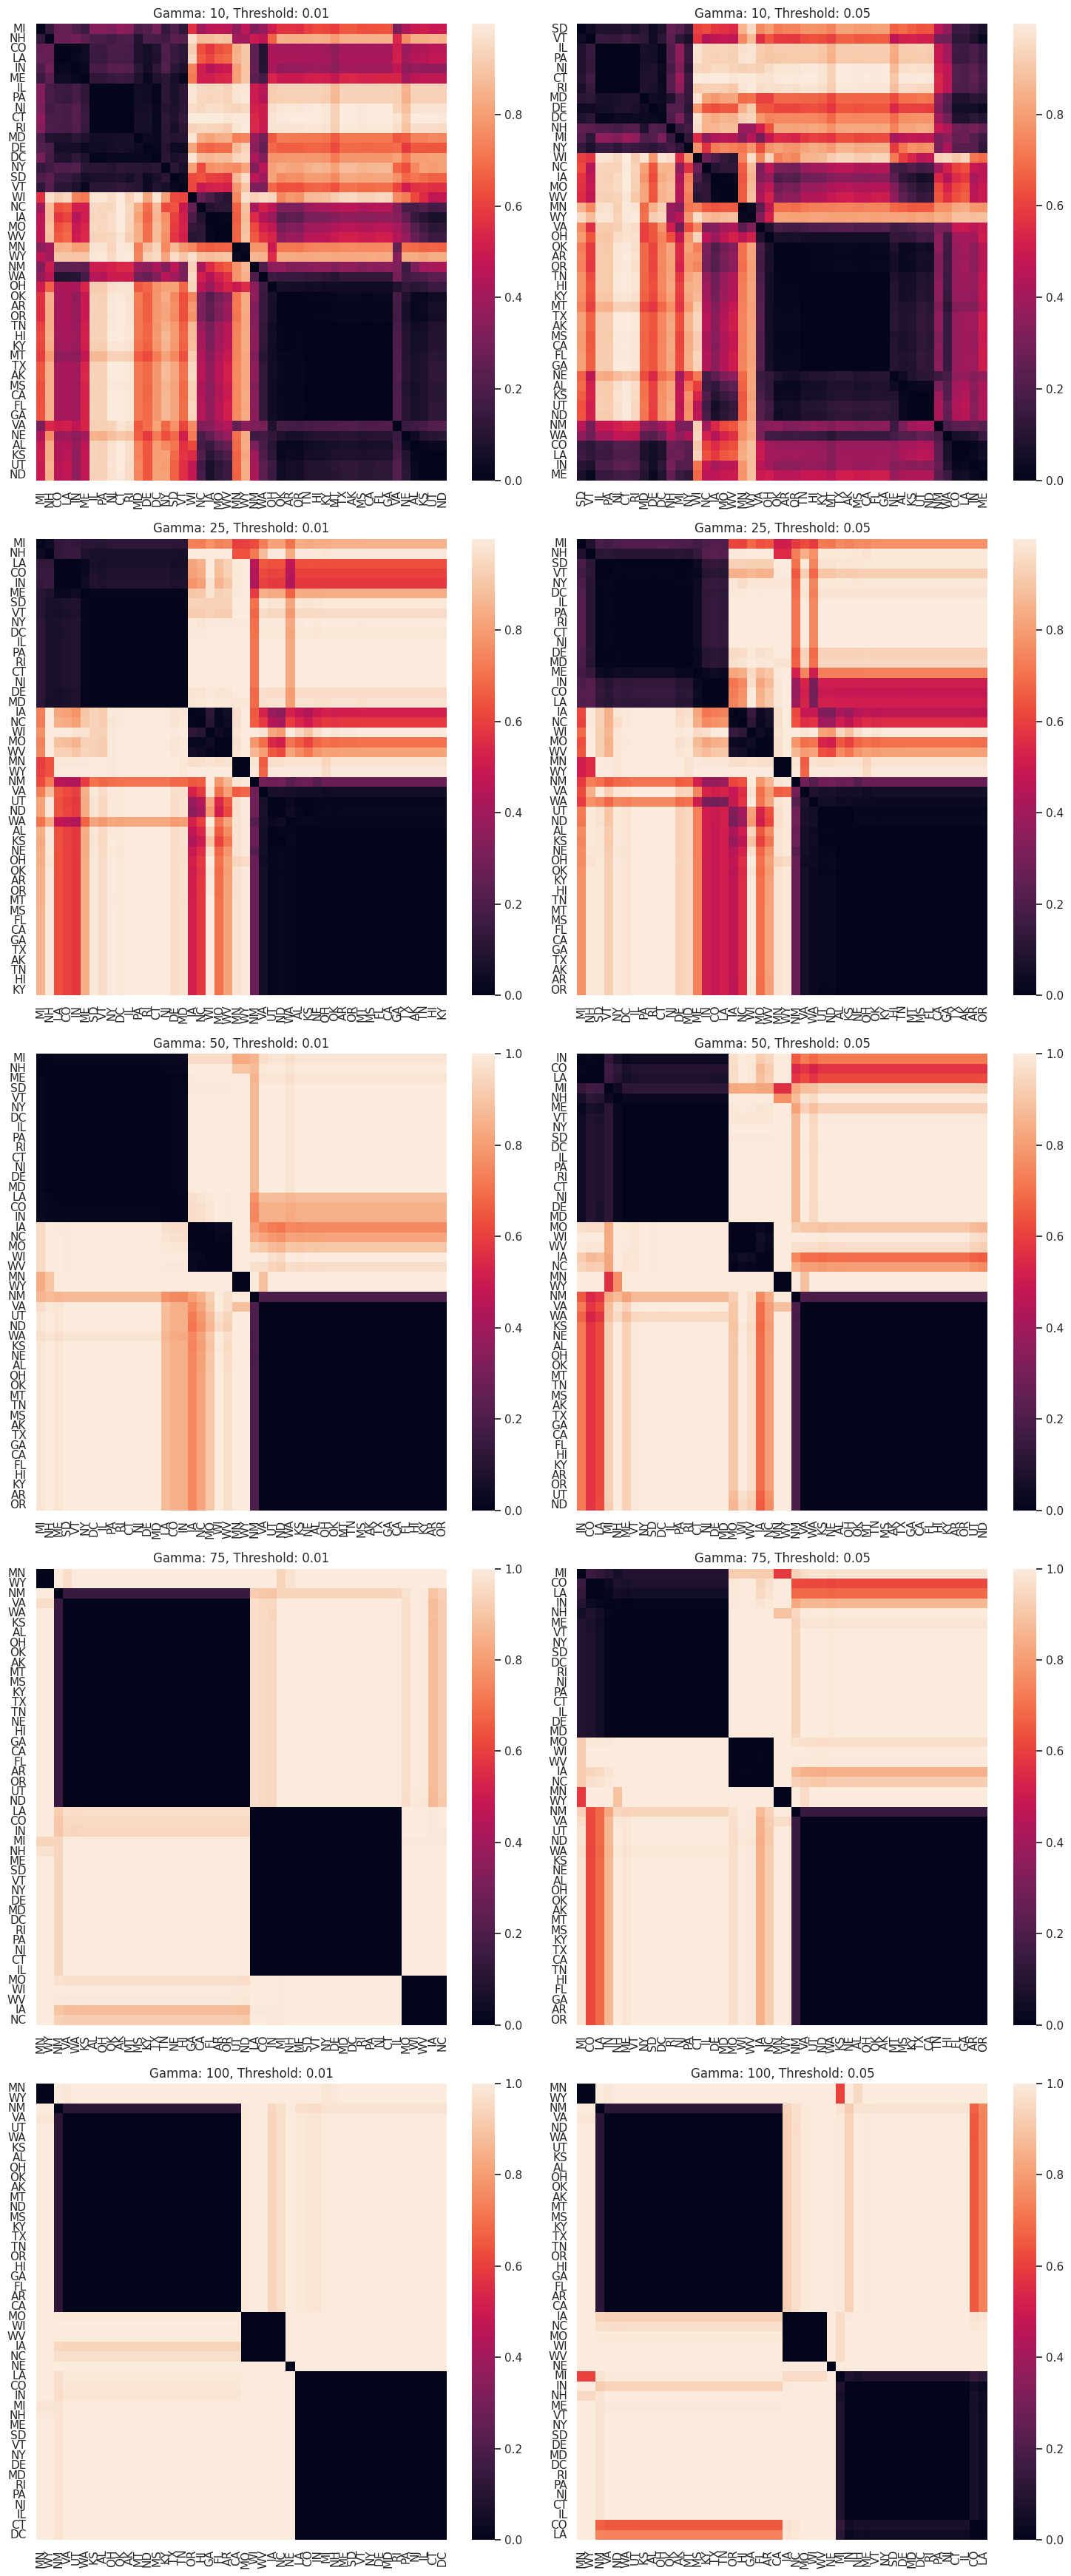

In [ ]:
search_params_for_granger(granger_results)

### The best Granger plot based on silhoutte score

Silhouette_avg:  0.9925942330336336


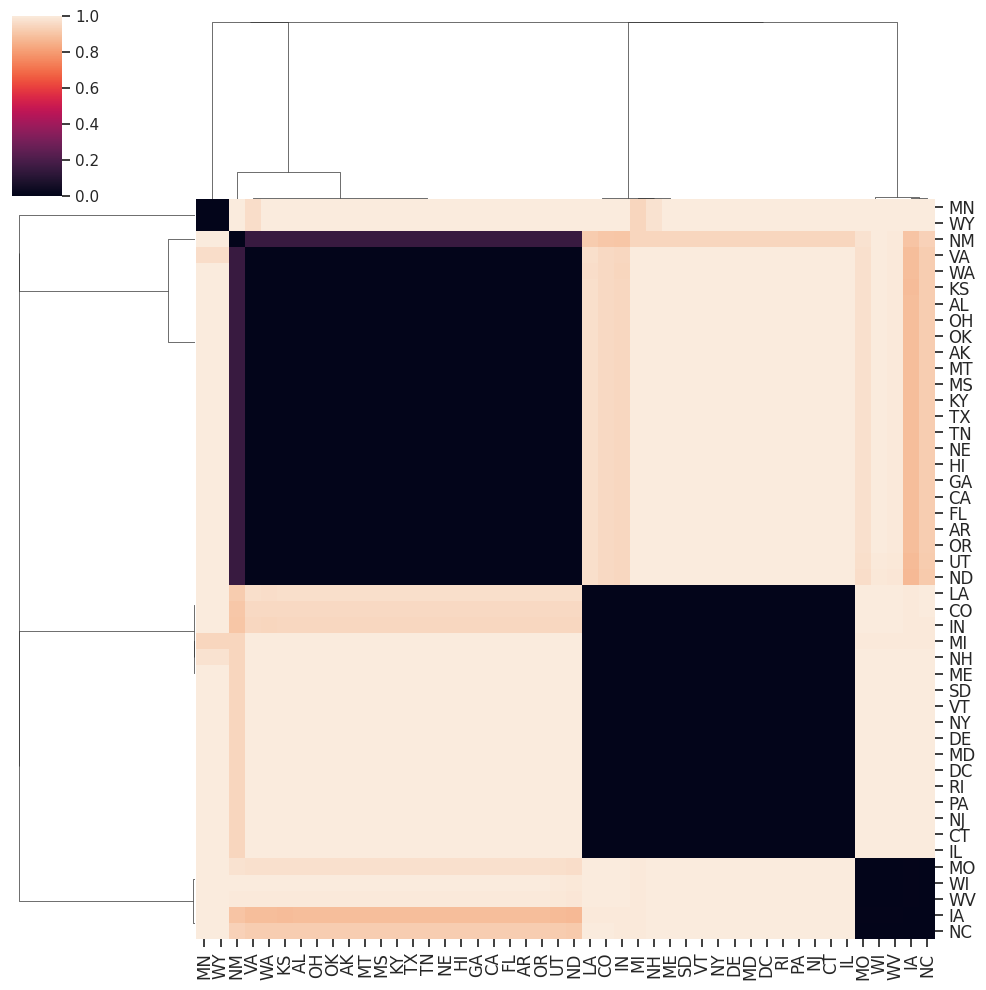

In [ ]:
granger_results_inv_best = 1 - 1 / (1 + np.exp(-75 * (granger_results - 0.01)))
best_granger_affinity_matrix = pairwise_distances(granger_results_inv_best, metric='cosine')
get_clustermap(best_granger_affinity_matrix, 4, "best_granger_cause_to_effect_affinity_clustermap", True)
granger_results_inv_for_2_clusters = 1 - 1 / (1 + np.exp(-50 * (granger_results - 0.01)))
two_cluster_granger_affinity_matrix = pairwise_distances(granger_results_inv_for_2_clusters, metric='cosine')

# Population Density Analysis

In [ ]:
df_pop_density = pd.read_csv(base_dir + 'pop_density.csv')
pop_density_dict = dict(zip(df_pop_density['state'], df_pop_density['Density']))

In [ ]:
def get_clustermap_pop_density(distance_matrix, num_clusters):
    if len(distance_matrix.shape) == 2 and distance_matrix.shape[0] == distance_matrix.shape[1]:
        distance_matrix_modified = squareform(distance_matrix) # linkage function wants a condensed upper triangular of the symmetric distance matrix

    linkage_matrix = linkage(distance_matrix_modified, method='complete')
    cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

    cluster_dict = {}
    for i in range(len(cluster_labels)):
        if (cluster_labels[i] in cluster_dict):
            cluster_dict[cluster_labels[i]]["states"].append(state_labels[i])
        else:
            cluster_dict[cluster_labels[i]] = {"states": [state_labels[i]]}

    for key in cluster_dict:
        temp_sum = 0
        for state in cluster_dict[key]["states"]:
            temp_sum += pop_density_dict[state]

        cluster_dict[key]['avg_pop_density'] = temp_sum / len(cluster_dict[key]["states"])

    return cluster_dict

In [ ]:
granger_cluster_pop_density_4 = get_clustermap_pop_density(best_granger_affinity_matrix, 4)
granger_cluster_pop_density_3 = get_clustermap_pop_density(best_granger_affinity_matrix, 3)
granger_cluster_pop_density_2 = get_clustermap_pop_density(two_cluster_granger_affinity_matrix, 2)

In [ ]:
dtw_cluster_pop_density_4 = get_clustermap_pop_density(dtw_a_b_affinity_matrix, 4)
dtw_cluster_pop_density_3 = get_clustermap_pop_density(dtw_a_b_affinity_matrix, 3)
dtw_cluster_pop_density_2 = get_clustermap_pop_density(dtw_a_b_affinity_matrix, 2)

In [ ]:
euc_cluster_pop_density_4 = get_clustermap_pop_density(euc_a_b_affinity_matrix, 4)
euc_cluster_pop_density_3 = get_clustermap_pop_density(euc_a_b_affinity_matrix, 3)
euc_cluster_pop_density_2 = get_clustermap_pop_density(euc_a_b_affinity_matrix, 2)

## Granger

In [ ]:
# prompt: use tablulate to put granger_cluster_pop_density_4, granger_cluster_pop_density_3, and granger_cluster_pop_density_2 into a table with columns Cluster 1, Cluster 2, Cluster 3, Cluster 4 and rows 2, 3, 4

from tabulate import tabulate

table_data = []
for num_clusters in [2, 3, 4]:
    row = []
    if num_clusters == 2:
        cluster_data = granger_cluster_pop_density_2
        for i in range(1, 3):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        for _ in range(2):
            row.append("")

    elif num_clusters == 3:
        cluster_data = granger_cluster_pop_density_3
        for i in range(1, 4):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        row.append("")

    elif num_clusters == 4:
        cluster_data = granger_cluster_pop_density_4
        for i in range(1, 5):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")


    table_data.append(row)

headers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
rows = ["2 Clusters", "3 Clusters", "4 Clusters"]
print(tabulate(table_data, headers=headers, tablefmt="grid", showindex=rows))



+------------+-------------+-------------+-------------+-------------+
|            |   Cluster 1 |   Cluster 2 | Cluster 3   | Cluster 4   |
+============+=============+=============+=============+=============+
| 2 Clusters |      915.76 |      101.5  |             |             |
+------------+-------------+-------------+-------------+-------------+
| 3 Clusters |      100.99 |      915.76 | 103.96      |             |
+------------+-------------+-------------+-------------+-------------+
| 4 Clusters |       36.2  |      106.88 | 915.76      | 103.96      |
+------------+-------------+-------------+-------------+-------------+


## Euc

In [ ]:
# prompt: use tablulate to put granger_cluster_pop_density_4, granger_cluster_pop_density_3, and granger_cluster_pop_density_2 into a table with columns Cluster 1, Cluster 2, Cluster 3, Cluster 4 and rows 2, 3, 4

from tabulate import tabulate

table_data = []
for num_clusters in [2, 3, 4]:
    row = []
    if num_clusters == 2:
        cluster_data = euc_cluster_pop_density_2
        for i in range(1, 3):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        for _ in range(2):
            row.append("")

    elif num_clusters == 3:
        cluster_data = euc_cluster_pop_density_3
        for i in range(1, 4):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        row.append("")

    elif num_clusters == 4:
        cluster_data = euc_cluster_pop_density_4
        for i in range(1, 5):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")


    table_data.append(row)

headers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
rows = ["2 Clusters", "3 Clusters", "4 Clusters"]
print(tabulate(table_data, headers=headers, tablefmt="grid", showindex=rows))



+------------+-------------+-------------+-------------+-------------+
|            |   Cluster 1 |   Cluster 2 | Cluster 3   | Cluster 4   |
+============+=============+=============+=============+=============+
| 2 Clusters |      420.63 |      399.69 |             |             |
+------------+-------------+-------------+-------------+-------------+
| 3 Clusters |      420.63 |      550.67 | 232.82      |             |
+------------+-------------+-------------+-------------+-------------+
| 4 Clusters |      420.63 |      550.67 | 133.46      | 290.77      |
+------------+-------------+-------------+-------------+-------------+


## DTW

In [ ]:
# prompt: use tablulate to put granger_cluster_pop_density_4, granger_cluster_pop_density_3, and granger_cluster_pop_density_2 into a table with columns Cluster 1, Cluster 2, Cluster 3, Cluster 4 and rows 2, 3, 4

from tabulate import tabulate

table_data = []
for num_clusters in [2, 3, 4]:
    row = []
    if num_clusters == 2:
        cluster_data = dtw_cluster_pop_density_2
        for i in range(1, 3):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        for _ in range(2):
            row.append("")

    elif num_clusters == 3:
        cluster_data = dtw_cluster_pop_density_3
        for i in range(1, 4):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")
        row.append("")

    elif num_clusters == 4:
        cluster_data = dtw_cluster_pop_density_4
        for i in range(1, 5):
            if i in cluster_data:
                row.append(round(cluster_data[i]["avg_pop_density"], 2))
            else:
                row.append("")


    table_data.append(row)

headers = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]
rows = ["2 Clusters", "3 Clusters", "4 Clusters"]
print(tabulate(table_data, headers=headers, tablefmt="grid", showindex=rows))



+------------+-------------+-------------+-------------+-------------+
|            |   Cluster 1 |   Cluster 2 | Cluster 3   | Cluster 4   |
+============+=============+=============+=============+=============+
| 2 Clusters |      420.63 |      399.69 |             |             |
+------------+-------------+-------------+-------------+-------------+
| 3 Clusters |      420.63 |      486.57 | 219.24      |             |
+------------+-------------+-------------+-------------+-------------+
| 4 Clusters |      420.63 |      486.57 | 126.57      | 298.67      |
+------------+-------------+-------------+-------------+-------------+


https://www.energy.gov/eere/vehicles/fact-661-february-7-2011-population-density

https://github.com/camillol/cs424p3/blob/master/data/Population-Density%20By%20State.csv


# Plotting the logistic transformations for addition to the Granger params search figure

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def sigmoid(gamma, b, x):
    return 1 - 1 / (1 + np.exp(-gamma * (x - b)))

# Define the x range and gamma values
x = np.linspace(-1, 1, 500)
gamma_values = [10, 25, 50, 75, 100]

# Create the figure and subplots

for gamma in gamma_values:
    plt.plot(x, sigmoid(gamma, 0.01, x))
    plt.xlabel(r'$g_{ij}$', fontsize=14)
    plt.ylabel(r'$\hat{g}_{ij}$', fontsize=14)
    plt.xlim(-0.3, 0.3)  # Restrict the x-axis to -0.5 to 0.5
    plt.grid(True)
    plt.savefig(output_dir +"logistic_transformations/gamma" + str(gamma) + "_t"+ str(1) + ".png")
    plt.clf()


for gamma in gamma_values:
    plt.plot(x, sigmoid(gamma, 0.05, x))
    plt.xlabel(r'$g_{ij}$', fontsize=14)
    plt.ylabel(r'$\hat{g}_{ij}$', fontsize=14)
    plt.xlim(-0.3, 0.3)  # Restrict the x-axis to -0.5 to 0.5
    plt.grid(True)
    plt.savefig(output_dir +"logistic_transformations/gamma" + str(gamma) + "_t"+ str(5) + ".png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

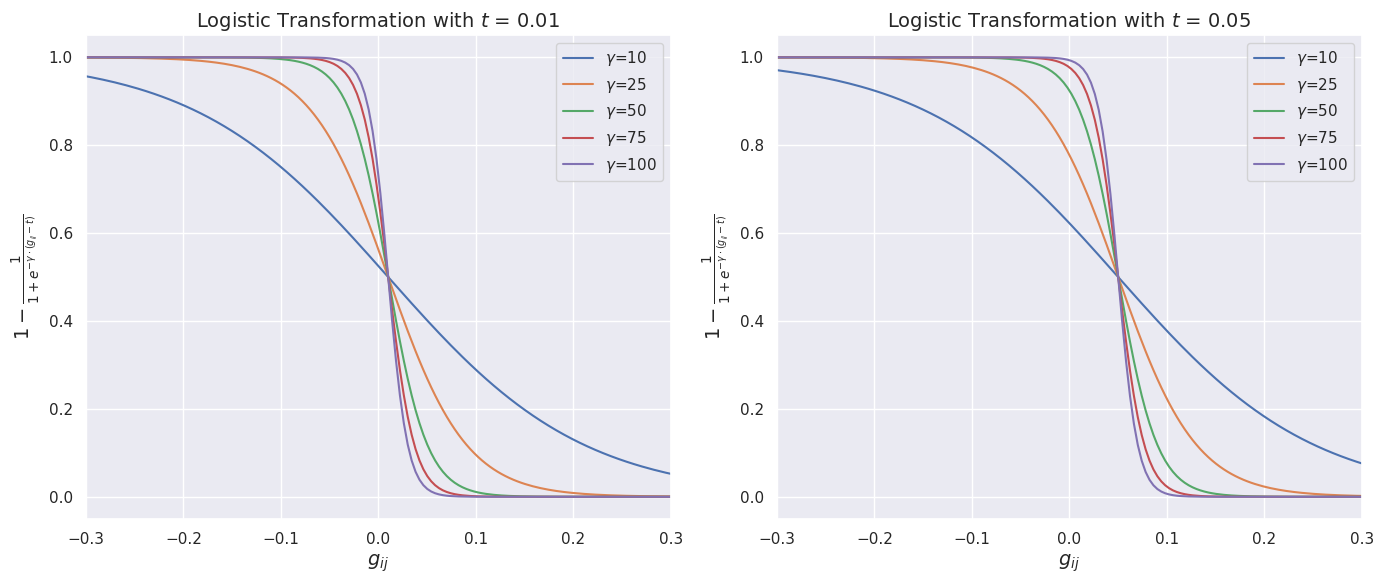

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def sigmoid(gamma, b, x):
    return 1 - 1 / (1 + np.exp(-gamma * (x - b)))

# Define the x range and gamma values
x = np.linspace(-1, 1, 500)
gamma_values = [10, 25, 50, 75, 100]

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the left subplot (b = 0.01)
b_left = 0.01
for gamma in gamma_values:
    axs[0].plot(x, sigmoid(gamma, b_left, x), label=r'$\gamma$={}'.format(gamma))
axs[0].set_title(r'Logistic Transformation with $t$ = 0.01', fontsize=14)
axs[0].set_xlabel(r'$g_{ij}$', fontsize=14)
axs[0].set_ylabel(r'$1 - \frac{1}{1 + e^{-\gamma \cdot (g_{ij} - t)}}$', fontsize=14)
axs[0].set_xlim(-0.3, 0.3)  # Restrict the x-axis to -0.5 to 0.5
axs[0].legend()
axs[0].grid(True)

# Plot for the right subplot (b = 0.05)
b_right = 0.05
for gamma in gamma_values:
    axs[1].plot(x, sigmoid(gamma, b_right, x), label=r'$\gamma$={}'.format(gamma))
axs[1].set_title(r'Logistic Transformation with $t$ = 0.05', fontsize=14)
axs[1].set_xlabel(r'$g_{ij}$', fontsize=14)
axs[1].set_ylabel(r'$1 - \frac{1}{1 + e^{-\gamma \cdot (g_{ij} - t)}}$', fontsize=14)
axs[1].set_xlim(-0.3, 0.3)  # Restrict the x-axis to -0.5 to 0.5
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()